In [1]:
"""
The script demonstrates a simple example of using ART with Keras. The example train a small model on the MNIST dataset
and creates adversarial examples using the Fast Gradient Sign Method. Here we use the ART classifier to train the model,
it would also be possible to provide a pretrained model to the ART classifier.
The parameters are chosen for reduced computational requirements of the script and not optimised for accuracy.
"""
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# https://stackoverflow.com/questions/42212810/tqdm-in-jupyter-notebook-prints-new-progress-bars-repeatedly
# replace tqdm imported by any other module with tqdm.notebook
import sys
import tqdm
from tqdm.notebook import tqdm
sys.modules["tqdm"].tqdm = tqdm
sys.modules["tqdm.tqdm"] = tqdm
import ipywidgets as widgets # check if this is installed to make normal tqdm work inside the notebook

import os
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('tensorflow').setLevel(logging.FATAL)

import numpy as np
import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input, VGG16

from art.estimators.classification import KerasClassifier

from art.attacks.evasion import SpatialTransformation
from art.attacks.evasion import FastGradientMethod

from art.defences.trainer import AdversarialTrainer

# from art.utils import load_mnist
from art.utils import load_dataset

#this is what makes the plots transparent in notebooks
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
# sn.set() #this changes the style of all plots, and imshow shows up wrong
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.externals import joblib

import time
import platform
import subprocess
import shutil
import load10_temp as ltemp

try:
    import tensorflow as tf
    # tf.config.run_functions_eagerly(False)
    tf.compat.v1.disable_eager_execution()
except:
    print("Failed to disable tensorflow eager execution")

Using TensorFlow backend.


In [2]:
def ends(df, n=5):
    '''Get the head and tail of a dataframe'''
    return df.head(n).append(df.tail(n))
    
# img_size = 32
# img_size = 176
# img_size = 180
img_size = 224
# img_size = 512

render_util_folder = os.getcwd()
if (platform.system() == "Windows"):
    blender_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\blender-2.78c-windows64" 
    dataset_folder = r"D:\Users\Enzo\Desktop\poke102938\School\RIT No Sync\Research\GAN\greebles-generator-master\Greebles_3DS_10"
else:
    blender_folder = r"/home/ec1018/projects/blender-2.78c-linux-glibc219-x86_64"
    dataset_folder = r"/home/ec1018/projects/Greebles_3DS_10"

render_folder = os.path.join(os.getcwd(), "greebles_10") #reduced dataset of 10

# Delete folder - comment and uncomment as you need
# if os.path.exists(render_folder) and os.path.isdir(render_folder):
#     shutil.rmtree(render_folder)
    
if not os.path.isdir(dataset_folder):
    raise OSError(2, 'No such directory', str(dataset_folder))
if not os.path.exists(os.path.join(render_util_folder, 'render.py')):
    raise OSError(2, 'render.py not found', str(render_util_folder))

render_script = os.path.join(render_util_folder, 'render.py')

# Find the correct version of blender depending on the OS
if (platform.system() == "Windows"):
    blender_exec = os.path.join(blender_folder, 'blender.exe')
else:
    blender_exec = os.path.join(blender_folder, 'blender')
    
if not os.path.exists(os.path.join(blender_folder, blender_exec)):
    raise OSError(2, 'Blender executable not found', str(blender_folder))

# If you want to split command automatically
# import shlex; shlex.split("/bin/prog -i data.txt -o \"more data.txt\"")
# https://janakiev.com/blog/python-shell-commands/


set_mode = 'specific_all'
set_type = 'specific_angle'
#####################################
# Generate training set
blender_process = subprocess.run([blender_exec, '-b', '-P', render_script, '--', 
                    '-st', set_type, '-sm', set_mode, '-rp', render_folder, '-dp', dataset_folder, '-rm', 'none', '-pf', 'tensorflow',
                    '-is', str(img_size), '-ni', '1', '-xr', '0', '-yr', '0', '-zr', '0'])

# Move training set to folder                    
source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
ltemp.move_to_folder(source_folder, os.path.join(source_folder, "train"))

In [3]:
# Step 1: Get training set

(x_train, y_train) = ltemp.load_dataset_temp("train", source_folder)
x_train = np.array(x_train, dtype='float64')
y_train = np.array(y_train, dtype='float32')

print(x_train.shape)
print(y_train.shape)
y_train

(10, 224, 224, 1)
(10, 10)


array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [4]:
# Put all the different angles in a dictionary to access individually later
all_test = {}

y_rot = 0
extra = "upsidedown"; y_rot = 180

test_set_gen_params = [-90, 90, 1]
# test_set_gen_params = [85, 90, 1]

try:
    test_set_name = "greebles10_{}_{}_{}_{}_{}.npy".format(extra,
                    test_set_gen_params[0], test_set_gen_params[1], test_set_gen_params[2], img_size)
except NameError:
    test_set_name = "greebles10_test_{}_{}_{}_{}.npy".format(
                    test_set_gen_params[0], test_set_gen_params[1], test_set_gen_params[2], img_size)

test_set_path = os.path.join(source_folder, test_set_name)

if not (os.path.isfile(test_set_path)):
    # Generate test set
    for z in range(test_set_gen_params[0], test_set_gen_params[1] + 1, test_set_gen_params[2]):

        blender_process = subprocess.run([blender_exec, '-b', '-P', render_script, '--', 
                            '-st', set_type, '-sm', set_mode, '-rp', render_folder, '-dp', dataset_folder, '-rm', 'none', '-pf', 'tensorflow',
                            '-is', str(img_size), '-ni', '1', '-xr', '0', '-yr', str(y_rot), '-zr', str(z)])

        # Move training set to folder                    
        source_folder = os.path.join(render_folder, "greebles_tf-" + set_mode, set_type)
        ltemp.move_to_folder(source_folder, os.path.join(source_folder, "test"))

        print(z, end=", ")
        (x_test, y_test) = ltemp.load_dataset_temp("test", source_folder)
        x_test = np.array(x_test, dtype='float64')
        y_test = np.array(y_test, dtype='float32')

        all_test[str(z)] = (x_test, y_test)
    
    # Save the concatenated set after loop
#     np.save(test_set_path, all_test) #not working with higher res images
    joblib.dump(all_test, test_set_path)


# all_test = np.load(test_set_path, allow_pickle=True).item()
all_test = joblib.load(test_set_path)
print("\n", all_test["90"][0].shape)


 (10, 224, 224, 1)


In [5]:
img_size = 224
extra = 'big'
model = load_model(os.path.join(os.getcwd(), 'model_{}_{}.h5'.format(img_size, extra)))
model.summary()












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
___________________________________

In [6]:
all_test.keys()

dict_keys(['-90', '-89', '-88', '-87', '-86', '-85', '-84', '-83', '-82', '-81', '-80', '-79', '-78', '-77', '-76', '-75', '-74', '-73', '-72', '-71', '-70', '-69', '-68', '-67', '-66', '-65', '-64', '-63', '-62', '-61', '-60', '-59', '-58', '-57', '-56', '-55', '-54', '-53', '-52', '-51', '-50', '-49', '-48', '-47', '-46', '-45', '-44', '-43', '-42', '-41', '-40', '-39', '-38', '-37', '-36', '-35', '-34', '-33', '-32', '-31', '-30', '-29', '-28', '-27', '-26', '-25', '-24', '-23', '-22', '-21', '-20', '-19', '-18', '-17', '-16', '-15', '-14', '-13', '-12', '-11', '-10', '-9', '-8', '-7', '-6', '-5', '-4', '-3', '-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', 

In [7]:
sample_idx = 0
(x_test, y_test) = np.copy(all_test[str(sample_idx)][0]), np.copy(all_test[str(sample_idx)][1])
# Normalize
x_test *= (1.0/255)
predictions_probs = model.predict_proba(x_test)
predictions_class = model.predict_classes(x_test)

In [8]:
print(predictions_class)
y_true = np.argmax(y_test, axis=1)
print(y_true)

[1 1 1 1 6 6 1 1 1 1]
[5 0 2 6 3 8 1 9 4 7]


In [9]:
print(model.predict_classes(x_test[0:2]))

print(model.predict(x_test[0:2]))
print(np.sum(model.predict(x_test[0:2]), axis=1))

[1 1]
[[1.5756788e-14 9.5655417e-01 1.9655419e-12 1.9621926e-05 9.6823351e-06
  3.2155456e-09 4.3416504e-02 9.6505555e-12 9.1132542e-09 1.7512228e-08]
 [2.7930835e-14 9.7979480e-01 6.1156282e-17 5.4478777e-09 1.5891583e-06
  1.4618158e-07 2.0203527e-02 1.4300702e-15 3.3681370e-11 1.7564881e-08]]
[1.        1.0000001]


In [10]:
print("Sum probs:", np.sum(predictions_probs, axis=1))
print("\nMax prob:", np.max(predictions_probs, axis=1))
display("All probs:", predictions_probs[0].argsort()[::-1])
print("")
# print(model.predict(x_test[0:2]).argsort(axis=1)[::-1])
# print(np.take_along_axis(a, sorted(range(len(a)), key=lambda i: a[i])))
# print(model.predict(x_test[0:2]))
top_classes = np.apply_along_axis(np.argsort, 1, model.predict(x_test[0:2]))
top_classes = np.apply_along_axis(np.flip, -1, top_classes)
print(top_classes)
# print(predictions_probs.argsort()[::-1])
display(model.predict(x_test[0:2]))

Sum probs: [1.         1.         1.         0.99999994 0.9999999  1.0000001
 0.99999994 1.         0.99999994 0.99999994]

Max prob: [0.9565543  0.9797948  0.9781684  0.9876945  0.5466031  0.49848226
 0.9965318  0.95846945 0.995777   0.9268536 ]


'All probs:'

array([1, 6, 3, 4, 9, 8, 5, 7, 2, 0])


[[1 6 3 4 9 8 5 7 2 0]
 [1 6 4 5 9 3 8 0 7 2]]


array([[1.5756788e-14, 9.5655417e-01, 1.9655419e-12, 1.9621926e-05,
        9.6823351e-06, 3.2155456e-09, 4.3416504e-02, 9.6505555e-12,
        9.1132542e-09, 1.7512228e-08],
       [2.7930835e-14, 9.7979480e-01, 6.1156282e-17, 5.4478777e-09,
        1.5891583e-06, 1.4618158e-07, 2.0203527e-02, 1.4300702e-15,
        3.3681370e-11, 1.7564881e-08]], dtype=float32)

In [11]:
all_acc = {}
all_probs = {}
raw_data = []
for k in all_test.keys():
    (x_test, y_test) = np.copy(all_test[k][0]), np.copy(all_test[k][1])
    # Normalize
    x_test *= (1.0/255)
    # Calculate accuracy
    predictions = model.predict(x_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(predictions, axis=1)
    accuracy = np.sum(y_pred == y_true) / len(y_test)
    all_acc[k] = accuracy
    y_pred_prob = np.max(predictions, axis=1)
    top_pred_categories = np.apply_along_axis(np.argsort, 1, predictions)
    top_pred_categories = np.apply_along_axis(np.flip, -1, top_pred_categories)
    print("Accuracy on {} degrees: {}%".format(k, accuracy * 100))
    # print("True:{tr}; Predicted:{pr}; Prob:{prob}".format(tr=np.argmax(y_test, axis=1), pr=np.argmax(predictions, axis=1), prob=np.max(predictions, axis=1)))
    for i in range(len(y_test)):
        n = [int(k), accuracy, y_true[i], y_pred[i], y_pred_prob[i], top_pred_categories[i]]
        n.extend(predictions[i])
        raw_data.append(n)


Accuracy on -90 degrees: 10.0%
Accuracy on -89 degrees: 10.0%
Accuracy on -88 degrees: 10.0%
Accuracy on -87 degrees: 10.0%
Accuracy on -86 degrees: 10.0%
Accuracy on -85 degrees: 10.0%
Accuracy on -84 degrees: 10.0%
Accuracy on -83 degrees: 10.0%
Accuracy on -82 degrees: 10.0%
Accuracy on -81 degrees: 10.0%
Accuracy on -80 degrees: 10.0%
Accuracy on -79 degrees: 10.0%
Accuracy on -78 degrees: 10.0%
Accuracy on -77 degrees: 10.0%
Accuracy on -76 degrees: 10.0%
Accuracy on -75 degrees: 10.0%
Accuracy on -74 degrees: 10.0%
Accuracy on -73 degrees: 10.0%
Accuracy on -72 degrees: 10.0%
Accuracy on -71 degrees: 10.0%
Accuracy on -70 degrees: 10.0%
Accuracy on -69 degrees: 10.0%
Accuracy on -68 degrees: 10.0%
Accuracy on -67 degrees: 10.0%
Accuracy on -66 degrees: 10.0%
Accuracy on -65 degrees: 10.0%
Accuracy on -64 degrees: 10.0%
Accuracy on -63 degrees: 10.0%
Accuracy on -62 degrees: 10.0%
Accuracy on -61 degrees: 10.0%
Accuracy on -60 degrees: 10.0%
Accuracy on -59 degrees: 10.0%
Accuracy

In [12]:
class_names = ltemp.get_class_names()
class_idx = [idx for idx, name in enumerate(class_names['train'])]

class_cols = ["Prob_C{}".format(i) for i in class_idx]
cols = ['z_angle', "acc", "y_true", "y_pred", "y_pred_prob", "top_pred_categories"]
cols.extend(class_cols)

df_main = pd.DataFrame(raw_data, columns=cols)

In [13]:
def df_column_switch(df, column1, column2):
    ''' Swaps two column positions by name in a dataframe.
    Source: https://stackoverflow.com/a/56693510/4017530 '''
    i = list(df.columns)
    a, b = i.index(column1), i.index(column2)
    i[b], i[a] = i[a], i[b]
    df = df[i]
    return df

df_main['top2_pred_categories'] = df_main['top_pred_categories'].apply(lambda x: x[:2])
df_main = df_column_switch(df_main, 'top_pred_categories', 'top2_pred_categories')

In [14]:
display(ends(df_main, n=2))
display(df_main.info())
display(df_main.describe())

,z_angle,acc,y_true,y_pred,y_pred_prob,top2_pred_categories,Prob_C0,Prob_C1,Prob_C2,Prob_C3,Prob_C4,Prob_C5,Prob_C6,Prob_C7,Prob_C8,Prob_C9,top_pred_categories
0,-90,0.1,5,1,0.994661,"[1, 6]",2.723567e-12,0.994661,1.612529e-10,7.422394e-07,0.000006,1.622788e-10,0.005332,1.698802e-12,6.332986e-13,4.571901e-11,"[1, 6, 4, 3, 5, 2, 9, 0, 7, 8]"
1,-90,0.1,0,1,0.994905,"[1, 6]",7.099875e-11,0.994905,3.130554e-12,2.281871e-07,0.000046,9.828935e-09,0.005049,5.062714e-14,2.871282e-13,3.112042e-10,"[1, 6, 4, 3, 5, 9, 0, 2, 8, 7]"
1808,90,0.1,3,1,0.989577,"[1, 6]",3.749774e-13,0.989577,1.303059e-14,5.412365e-10,0.000023,5.715054e-08,0.010398,1.374737e-13,5.239868e-12,1.285421e-06,"[1, 6, 4, 9, 5, 3, 8, 0, 7, 2]"
1809,90,0.1,4,1,0.995019,"[1, 6]",6.137778e-11,0.995019,8.803070e-11,5.829841e-06,0.000005,1.974175e-09,0.004971,6.491759e-14,8.415178e-12,1.818391e-11,"[1, 6, 3, 4, 5, 2, 0, 9, 8, 7]"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1810 entries, 0 to 1809
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   z_angle               1810 non-null   int64  
 1   acc                   1810 non-null   float64
 2   y_true                1810 non-null   int64  
 3   y_pred                1810 non-null   int64  
 4   y_pred_prob           1810 non-null   float64
 5   top2_pred_categories  1810 non-null   object 
 6   Prob_C0               1810 non-null   float64
 7   Prob_C1               1810 non-null   float64
 8   Prob_C2               1810 non-null   float64
 9   Prob_C3               1810 non-null   float64
 10  Prob_C4               1810 non-null   float64
 11  Prob_C5               1810 non-null   float64
 12  Prob_C6               1810 non-null   float64
 13  Prob_C7               1810 non-null   float64
 14  Prob_C8               1810 non-null   float64
 15  Prob_C9              

None

,z_angle,acc,y_true,y_pred,y_pred_prob,Prob_C0,Prob_C1,Prob_C2,Prob_C3,Prob_C4,Prob_C5,Prob_C6,Prob_C7,Prob_C8,Prob_C9
count,1810.000000,1810.0,1810.000000,1810.000000,1810.000000,1.810000e+03,1810.000000,1.810000e+03,1.810000e+03,1.810000e+03,1.810000e+03,1810.000000,1.810000e+03,1.810000e+03,1.810000e+03
mean,0.000000,0.1,4.500000,1.138122,0.928922,3.763621e-05,0.927818,1.945564e-09,2.452906e-04,8.688005e-03,7.465051e-07,0.063152,1.703366e-08,2.596596e-05,3.204789e-05
std,52.263841,0.0,2.873075,0.819696,0.127239,2.336720e-04,0.130912,7.864488e-09,9.268584e-04,4.516637e-02,2.965251e-06,0.124479,8.165340e-08,1.393088e-04,1.477594e-04
min,-90.000000,0.1,0.000000,1.000000,0.498482,2.970508e-17,0.453181,1.978264e-17,8.155056e-14,1.058954e-08,4.928600e-12,0.002007,8.465701e-16,6.379511e-16,1.953266e-12
25%,-45.000000,0.1,2.000000,1.000000,0.957779,5.241883e-15,0.957779,1.218229e-14,1.588189e-09,4.472935e-07,1.606618e-09,0.007378,7.823233e-14,7.797138e-13,8.805054e-10
50%,0.000000,0.1,4.500000,1.000000,0.983682,5.389085e-14,0.983682,2.042788e-12,1.499355e-07,3.559007e-06,4.287596e-08,0.015815,5.254792e-13,2.576310e-11,6.390792e-08
75%,45.000000,0.1,7.000000,1.000000,0.992306,4.137279e-12,0.992306,1.165672e-10,8.237386e-06,3.446244e-05,1.510878e-07,0.035161,1.936723e-11,4.750045e-09,2.191884e-06
max,90.000000,0.1,9.000000,6.000000,0.997993,2.640865e-03,0.997993,7.171190e-08,7.957205e-03,3.629158e-01,2.591469e-05,0.546603,7.705391e-07,1.286059e-03,1.348911e-03


In [15]:
def misclassified(row):
    if row['y_true'] == row['y_pred']:
        return 0
    else:
        return 1

# df_main['acc'] = df_main['acc'].astype(str)
df_main['misclassified'] = df_main.apply (lambda row: misclassified(row), axis=1)
multi = df_main.set_index(['z_angle', 'acc', 'misclassified'], inplace=False).sort_index()
multi = multi.reset_index().sort_values(
    ['z_angle', 'acc', 'misclassified', 'y_pred_prob'], ascending=[1,1,1,0]
    ).set_index(['z_angle', 'acc', 'misclassified'])

display(multi[:30])

y_true  y_pred  y_pred_prob top2_pred_categories  \
z_angle acc misclassified                                                     
-90     0.1 0                   1       1     0.974926               [1, 6]   
            1                   2       1     0.997862               [1, 6]   
            1                   4       1     0.997835               [1, 6]   
            1                   9       1     0.997223               [1, 6]   
            1                   0       1     0.994905               [1, 6]   
            1                   5       1     0.994661               [1, 6]   
            1                   6       1     0.993404               [1, 6]   
            1                   3       1     0.989860               [1, 6]   
            1                   7       1     0.983734               [1, 6]   
            1                   8       1     0.833776               [1, 6]   
-89     0.1 0                   1       1     0.974280               [1, 6]   
            1                   2       1     0.997908               [1, 6]   
            1                   4       1     0.997795               [1, 6]   
            1                   9       1     0.997201               [1, 6]   
            1                   0       1     0.994845               [1, 6]   
            1                   5       1     0.994627               [1, 6]   
            1                   6       1     0.993469               [1, 6]   
            1                   3       1     0.989861               [1, 6]   
            1                   7       1     0.984083               [1, 6]   
            1                   8       1     0.829891               [1, 6]   
-88     0.1 0                   1       1     0.973405               [1, 6]   
            1                   2       1     0.997916               [1, 6]   
            1                   4       1     0.997682               [1, 6]   
            1                   9       1     0.997160               [1, 6]   
            1                   0       1     0.994803               [1, 6]   
            1                   5       1     0.994672               [1, 6]   
            1                   6       1     0.993500               [1, 6]   
            1                   3       1     0.989688               [1, 6]   
            1                   7       1     0.984140               [1, 6]   
            1                   8       1     0.830636               [1, 6]   

                                Prob_C0   Prob_C1       Prob_C2       Prob_C3  \
z_angle acc misclassified                                                       
-90     0.1 0              6.931580e-05  0.974926  2.967077e-10  3.274851e-08   
            1              4.005441e-13  0.997862  5.591542e-16  9.657992e-14   
            1              9.241131e-12  0.997835  3.251036e-11  7.214830e-07   
            1              2.615762e-16  0.997223  1.704294e-10  4.756238e-06   
            1              7.099875e-11  0.994905  3.130554e-12  2.281871e-07   
            1              2.723567e-12  0.994661  1.612529e-10  7.422394e-07   
            1              5.396280e-11  0.993404  3.075410e-12  1.937856e-10   
            1              2.746020e-13  0.989860  8.424774e-15  1.360755e-10   
            1              6.326467e-15  0.983734  2.979339e-15  1.904261e-12   
            1              1.774563e-14  0.833776  1.370083e-12  4.887775e-08   
-89     0.1 0              8.896739e-05  0.974280  3.216792e-10  3.549540e-08   
            1              4.258571e-13  0.997908  5.521976e-16  8.970553e-14   
            1              1.054092e-11  0.997795  3.541770e-11  7.730893e-07   
            1              2.706352e-16  0.997201  1.966609e-10  5.019433e-06   
            1              7.870942e-11  0.994845  3.398777e-12  2.455992e-07   
            1              3.038590e-12  0.994627  1.828874e-10  8.107564e-07   
            1              5.826242e-11 

In [16]:
df_main.to_csv("model_224_big_upsidedown.csv")
# display(df_main[df_main["z_angle"] == -90])

# # get only misclassifications
# multi.xs([1,], level=[2,])

display(df_main[df_main["y_true"] == 7])

,z_angle,acc,y_true,y_pred,y_pred_prob,top2_pred_categories,Prob_C0,Prob_C1,Prob_C2,Prob_C3,Prob_C4,Prob_C5,Prob_C6,Prob_C7,Prob_C8,Prob_C9,top_pred_categories,misclassified
7,-90,0.1,7,1,0.983734,"[1, 6]",6.326467e-15,0.983734,2.979339e-15,1.904261e-12,5.953159e-08,8.540935e-08,0.016264,6.900063e-14,1.769868e-13,0.000002,"[1, 6, 9, 5, 4, 3, 8, 7, 0, 2]",1
17,-89,0.1,7,1,0.984083,"[1, 6]",6.529453e-15,0.984083,2.923496e-15,1.801082e-12,5.627290e-08,8.680679e-08,0.015915,6.663817e-14,1.669086e-13,0.000002,"[1, 6, 9, 5, 4, 3, 8, 7, 0, 2]",1
27,-88,0.1,7,1,0.984140,"[1, 6]",6.460553e-15,0.984140,2.915534e-15,1.775251e-12,5.435133e-08,8.374332e-08,0.015859,6.599928e-14,1.622313e-13,0.000002,"[1, 6, 9, 5, 4, 3, 8, 7, 0, 2]",1
37,-87,0.1,7,1,0.984164,"[1, 6]",6.420151e-15,0.984164,2.902811e-15,1.727057e-12,5.102643e-08,8.316282e-08,0.015834,6.580331e-14,1.585510e-13,0.000001,"[1, 6, 9, 5, 4, 3, 8, 7, 0, 2]",1
47,-86,0.1,7,1,0.984476,"[1, 6]",6.145110e-15,0.984476,2.948501e-15,1.690251e-12,4.739433e-08,7.686200e-08,0.015523,6.470275e-14,1.486650e-13,0.000001,"[1, 6, 9, 5, 4, 3, 8, 7, 0, 2]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,86,0.1,7,1,0.982265,"[1, 6]",4.626107e-15,0.982265,6.531002e-15,5.140183e-12,4.626873e-08,6.274180e-08,0.017733,2.201498e-13,2.904825e-13,0.000002,"[1, 6, 9, 5, 4, 3, 8, 7, 2, 0]",1
1774,87,0.1,7,1,0.981810,"[1, 6]",4.859258e-15,0.981810,6.275910e-15,5.028196e-12,4.982001e-08,6.717673e-08,0.018188,2.165146e-13,2.951241e-13,0.000002,"[1, 6, 9, 5, 4, 3, 8, 7, 2, 0]",1
1784,88,0.1,7,1,0.981247,"[1, 6]",4.878809e-15,0.981247,6.462632e-15,5.233886e-12,5.295895e-08,6.905490e-08,0.018751,2.267423e-13,3.134135e-13,0.000002,"[1, 6, 9, 5, 4, 3, 8, 7, 2, 0]",1
1794,89,0.1,7,1,0.980725,"[1, 6]",5.189574e-15,0.980725,6.276439e-15,5.247942e-12,5.815350e-08,7.511640e-08,0.019272,2.255475e-13,3.269720e-13,0.000002,"[1, 6, 9, 5, 4, 3, 8, 7, 2, 0]",1


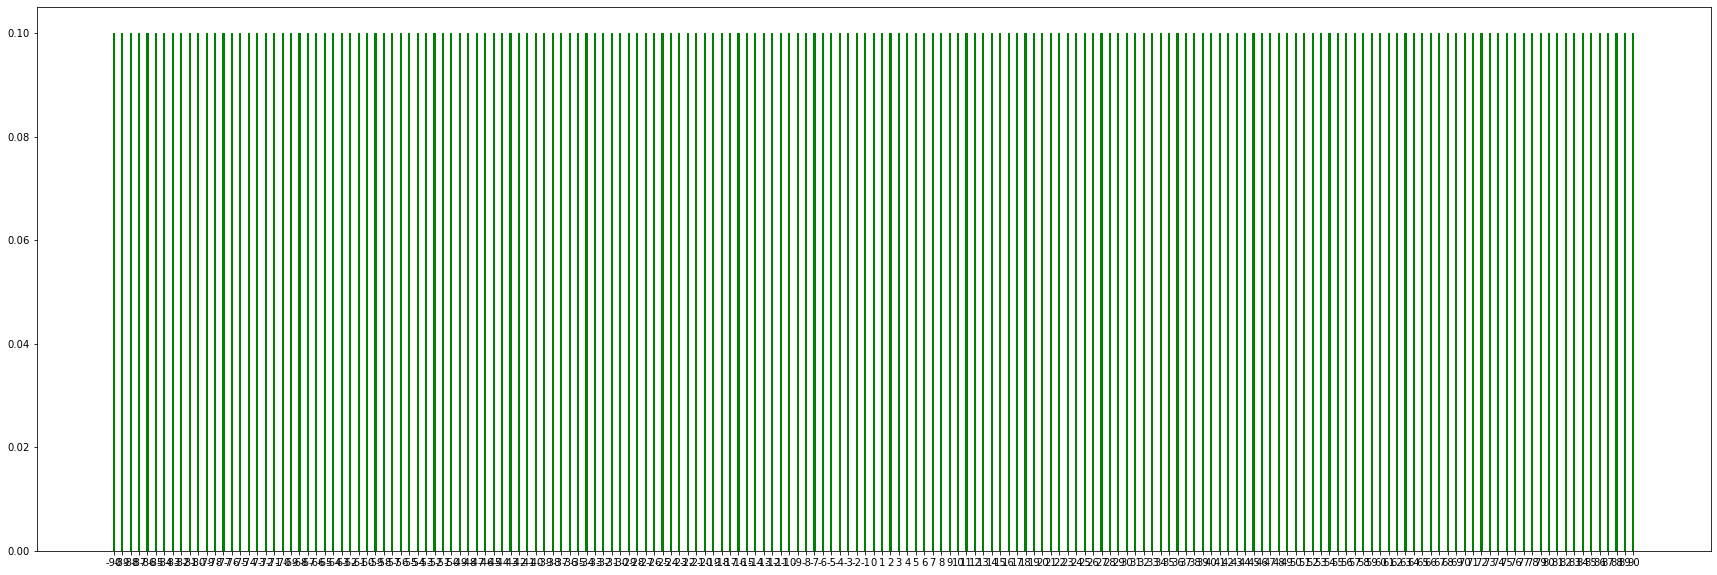

In [17]:
fig = plt.figure(figsize=(30,10))
plt.bar(all_acc.keys(), all_acc.values(), width = 0.25, color='g')
plt.show()

In [18]:
# # Clear allocated memory for the GPU
# try:
#     from numba import cuda
#     cuda.select_device(0)
#     cuda.close()
#     print("Cleared memory")
# except:
#     print("Could not clear memory")

# print(time.strftime("%Y/%m/%d; %H:%M:%S", time.localtime()))